In [1]:
import sys, os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from typing import List, Tuple, Callable, Any, Dict

from methods.PolyCG.polycg.transforms.transform_marginals import send_to_back_permutation
from methods.midstep_composites import midstep_composition_transformation, midstep_groundstate, midstep_groundstate_se3
from methods.midstep_composites import midstep_composition_transformation_correction, midstep_composition_transformation_correction_old
from methods.read_nuc_data import read_nucleosome_triads, GenStiffness
from methods.free_energy import calculate_midstep_triads, midstep_excess_vals
from methods.PolyCG.polycg.SO3 import so3

from methods.nearest_correlation import nearcorr

# from methods.PolyCG.polycg.SO3 import so3
# from methods.PolyCG.polycg.transforms.transform_SO3 import euler2rotmat_so3
# from methods.PolyCG.polycg.cgnaplus import cgnaplus_bps_params
# from methods.PolyCG.polycg.transforms.transform_algebra2group import algebra2group_lintrans, group2algebra_lintrans

np.set_printoptions(linewidth=250,precision=5,suppress=True)

-----
-----
# Methods
-----
-----

### Matrix Methods

In [2]:
def plot_matrix(mat,dims=6,cmap='gray_r'):
    mat = np.copy(mat)
    fig = plt.figure(figsize=(17./2.54*1.3,17.2/2.54))
    ax1 = fig.add_subplot(111)
    
    img = ax1.imshow(mat, interpolation='none', cmap=cmap)
    # plot blocks
    for l in range(1,len(mat)//dims+1):
        ax1.plot([l*dims-0.6,l*dims-0.6],[0-0.5,len(mat)-0.5],color='black',lw=0.5)
        ax1.plot([0-0.5,len(mat)-0.5],[l*dims-0.4,l*dims-0.4],color='black',lw=0.5)

        ax1.plot([l*dims-0.6,l*dims-0.6],[(l-1)*dims-0.5,l*dims-0.5],color='red',lw=0.5)
        ax1.plot([(l-1)*dims-0.6,(l-1)*dims-0.6],[(l-1)*dims-0.5,l*dims-0.5],color='red',lw=0.5)
        ax1.plot([(l-1)*dims-0.5,l*dims-0.5],[l*dims-0.4,l*dims-0.4],color='red',lw=0.5)
        ax1.plot([(l-1)*dims-0.5,l*dims-0.5],[(l-1)*dims-0.4,(l-1)*dims-0.4],color='red',lw=0.5)
        
    ax1.set_xlim((-0.5,len(mat)-.5))
    ax1.set_ylim((-0.5,len(mat)-.5))
    # ax1.set_xlim((-0.5,12-.5))
    # ax1.set_ylim((-0.5,12-.5))
    fig.colorbar(img, ax=ax1)
    plt.show()
    
def regularize_matrix(A, epsilon=1e-6):
    # (Optional) ensure A is symmetric to avoid floating-point asymmetries
    A_sym = 0.5 * (A + A.T)
    # Eigen-decomposition for symmetric (real) matrices
    eigenvals, Q = np.linalg.eigh(A_sym)
    # Lift eigenvalues below epsilon to epsilon
    eigenvals_clipped = np.clip(eigenvals, epsilon, None)
    # Reconstruct the matrix
    A_reg = Q @ np.diag(eigenvals_clipped) @ Q.T
    # A_reg is guaranteed to be real and symmetric
    A_reg = A_reg.astype(np.float64)
    return A_reg

def block_sum(M,dims):
    if len(M)%dims != 0:
        raise ValueError('Matrix dimension not a multiple of dims.')
    N = len(M)//dims
    bM = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            bM[i,j] = np.max(M[i*dims:(i+1)*dims,j*dims:(j+1)*dims])
    return bM

def is_positive_definite(matrix):
    if not np.allclose(matrix, matrix.T):
        print('Not allclose')
        return False
    eigenvalues = np.linalg.eigvals(matrix)
    return np.all(eigenvalues > 0)

def is_regular(A):
    if A.shape[0] != A.shape[1]:
        return False
    return np.linalg.matrix_rank(A) == A.shape[0]

def marginalize_diagonal_blocks(K: np.ndarray,dim: int=6):
    cov = np.linalg.inv(K)
    dcov = np.zeros(cov.shape)
    for i in range(len(K)//dim):
        dcov[i*dim:(i+1)*dim,i*dim:(i+1)*dim] = cov[i*dim:(i+1)*dim,i*dim:(i+1)*dim]
    dK = np.linalg.inv(dcov)
    return dK


### Selection Methods

In [3]:
def get_midstep_locations(left_open: int, right_open: int, base_locations = None, sort = True):
    if base_locations is None:
        MIDSTEP_LOCATIONS = [
            2, 6, 14, 17, 24, 29, 
            34, 38, 45, 49, 55, 59, 
            65, 69, 76, 80, 86, 90, 
            96, 100, 107, 111, 116, 121, 
            128, 131, 139, 143
        ]
    else:
        MIDSTEP_LOCATIONS = base_locations
    if left_open + right_open > len(MIDSTEP_LOCATIONS):
        return []
    
    locs = MIDSTEP_LOCATIONS[left_open:len(MIDSTEP_LOCATIONS)-right_open]
    if sort:
        locs = sorted(list(set(locs)))
    return locs

def submatrix(M, dim: int = 6, left_open: int = 0, right_open: int = 0, marginalize=False):
    n = len(M)//dim
    if marginalize:
        return np.linalg.inv(np.linalg.inv(M)[left_open*dim:(n-right_open)*dim,left_open*dim:(n-right_open)*dim])
    return M[left_open*dim:(n-right_open)*dim,left_open*dim:(n-right_open)*dim]

### Binding Model Methods

In [4]:
def Hinverse(Psi):
    psih = so3.hat_map(Psi)
    psihsq = psih @ psih
    Hinv = np.eye(3)
    Hinv += 0.5* psih
    Hinv += 1./12 * psihsq
    Hinv -= 1./720 * psihsq @ psihsq
    Hinv += 1./30240 * psihsq @ psihsq @ psihsq
    return Hinv
    
def coordinate_transformation(muk0s,sks):
    B = np.zeros((len(sks)*6,len(muk0s)*6))
    Pbar = np.zeros(len(sks)*6)
    for k in range(len(sks)):
        sig0 = np.linalg.inv(muk0s[k]) @ muk0s[k+1]
        Sig  = sig0[:3,:3]
        sig  = sig0[:3,3]
        Sk   = sks[k,:3,:3]
        sk   = sks[k,:3,3]
        
        Psi  = so3.rotmat2euler(Sk.T @ Sig)
        Hi   = Hinverse(Psi)
        Bkm = np.zeros((6,6))
        Bkp = np.zeros((6,6))
        Bkm[:3,:3] = -Hi @ Sig.T
        Bkm[3:,:3] = Sk.T @ so3.hat_map(sig)
        Bkm[3:,3:] = -Sk.T
        Bkp[:3,:3] = Hi
        Bkp[3:,3:] = Sk.T @ Sig
        
        B[6*k:6*(k+1),6*k:6*(k+1)]      = Bkm
        B[6*k:6*(k+1),6*(k+1):6*(k+2)]  = Bkp
        
        Pbar[k*6:k*6+3]   = Psi
        Pbar[k*6+3:k*6+6] = Sk.T @ (sig-sk)
    return B, Pbar

def coordinate_transformation_correction(muk0s,sks,Z_delta_ref):
    
    if len(Z_delta_ref.shape) < 2:
        Z_delta_ref = Z_delta_ref.reshape((len(Z_delta_ref)//6,6))
    
    B = np.zeros((len(sks)*6,len(muk0s)*6))
    Pbar = np.zeros(len(sks)*6)
    for k in range(len(sks)):
        sig0 = np.linalg.inv(muk0s[k]) @ muk0s[k+1]
        SIG  = sig0[:3,:3]
        sig  = sig0[:3,3]
        Sk   = sks[k,:3,:3]
        sk   = sks[k,:3,3]
        
        Psi  = so3.rotmat2euler(Sk.T @ SIG)
        Hi   = Hinverse(Psi)
        
        Z0k = so3.euler2rotmat(Z_delta_ref[k,:3])
        htheta0 = so3.hat_map(Z_delta_ref[k,:3])
        
        Bkm = np.zeros((6,6))
        Bkp = np.zeros((6,6))
        
        Bkm[:3,:3] = -Hi @ SIG.T
        Bkm[3:,:3] = Sk.T @ so3.hat_map(sig)
        Bkm[3:,3:] = -Sk.T @ Z0k.T
        
        Bkp[:3,:3] = Hi
        Bkp[3:,3:] = Sk.T @ Z0k.T @ SIG
        
        B[6*k:6*(k+1),6*k:6*(k+1)]      = Bkm
        B[6*k:6*(k+1),6*(k+1):6*(k+2)]  = Bkp
        
        Pbar[k*6:k*6+3]   = Psi
        Pbar[k*6+3:k*6+6] = Sk.T @ ( (Z0k.T + htheta0) @ sig-sk)
    return B, Pbar



### Free Energy

In [ ]:

def binding_model_free_energy(
    free_gs: np.ndarray,
    free_M: np.ndarray,    
    nuc_mu0: np.ndarray,
    nuc_K: np.ndarray,
    left_open: int,
    right_open: int,
    NUCLEOSOME_TRIADS: np.ndarray,
    use_correction: bool = True,
) -> np.ndarray:

    midstep_constraint_locations = get_midstep_locations(left_open, right_open)
    if len(midstep_constraint_locations) <= 1:
        n = len(free_M)
        F_pi = -0.5*n * np.log(2*np.pi)
        # matrix term
        logdet_sign, logdet = np.linalg.slogdet(free_M)
        F_mat = 0.5*logdet
        F = F_mat + F_pi  
        Fdict = {
            'F': F,
            'F_entropy' : F,
            'F_enthalpy': 0,
            'F_jacob'   : 0,
            'F_free'    : F
        }
        return Fdict
    
    # FOR NOW WE USE THE FIXED MIDSTEP TRIADS AS MU_0
    # Find midstep triads in fixed framework for comparison
    FIXED_midstep_triads = calculate_midstep_triads(
        midstep_constraint_locations,
        NUCLEOSOME_TRIADS
    )
    nuc_mu0 = FIXED_midstep_triads
    
    sks = midstep_groundstate_se3(free_gs,midstep_constraint_locations)
    
    # find composite transformation
    transform, replaced_ids = midstep_composition_transformation(
        free_gs,
        midstep_constraint_locations
    )
    
    # transform stiffness matrix
    inv_transform = np.linalg.inv(transform)
    M_transformed = inv_transform.T @ free_M @ inv_transform
    
    # rearrange stiffness matrix
    full_replaced_ids = list()
    for i in range(len(replaced_ids)):
        full_replaced_ids += [6*replaced_ids[i]+j for j in range(6)]
     
    P = send_to_back_permutation(len(free_M),full_replaced_ids)
    M_rearranged = P @ M_transformed @ P.T
    
    # select M and R submatrices
    N  = len(M_rearranged)
    NC = len(full_replaced_ids)
    NF = N-NC
    
    M_R = M_rearranged[:NF,:NF]
    M_M = M_rearranged[NF:,NF:]
    M_RM = M_rearranged[:NF,NF:]
    
    # Calculate M block marginal
    M_Mp = M_M - M_RM.T @ np.linalg.inv(M_R) @ M_RM
    M_Mp = 0.5*(M_Mp+M_Mp.T)
    

    ##############################################
    # Binding Model
    ##############################################
    
    nuc_K *= 1
    
    # Calculate Incidence Matrix
    B, Pbar = coordinate_transformation(nuc_mu0,sks)  
    Kcomb = nuc_K + B.T @ M_Mp @ B
    # calculate ground state
    alpha = -np.linalg.inv(Kcomb) @ B.T @ M_Mp @ Pbar
    
    B, Pbar = coordinate_transformation_correction(nuc_mu0,sks,alpha)
    Kcomb = nuc_K + B.T @ M_Mp @ B
    # calculate ground state
    alpha = -np.linalg.inv(Kcomb) @ B.T @ M_Mp @ Pbar
    
    
    Y_C = Pbar + B @ alpha
    C = 0.5* Pbar.T @ ( M_Mp - M_Mp @ B @ np.linalg.inv(Kcomb) @ B.T @ M_Mp ) @ Pbar
    # print(f'C = {C}')
    
    gamma = -np.linalg.inv(M_R) @ M_RM @ Y_C
    
    if use_correction:
    
        gs_transf_perm = np.concatenate((gamma,Y_C))
        gs_transf = P.T @ gs_transf_perm
        gs = inv_transform @ gs_transf

        gs = gs.reshape((len(gs)//6,6))
        # find composite transformation
        transform, replaced_ids = midstep_composition_transformation_correction_old(
            free_gs,
            midstep_constraint_locations,
            -gs
        )
        
        # transform stiffness matrix
        inv_transform = np.linalg.inv(transform)
        M_transformed = inv_transform.T @ free_M @ inv_transform
        
        # rearrange stiffness matrix
        full_replaced_ids = list()
        for i in range(len(replaced_ids)):
            full_replaced_ids += [6*replaced_ids[i]+j for j in range(6)]
        
        P = send_to_back_permutation(len(free_M),full_replaced_ids)
        M_rearranged = P @ M_transformed @ P.T
        
        # select M and R submatrices
        N  = len(M_rearranged)
        NC = len(full_replaced_ids)
        NF = N-NC
        
        M_R = M_rearranged[:NF,:NF]
        M_M = M_rearranged[NF:,NF:]
        M_RM = M_rearranged[:NF,NF:]
        
        # Calculate M block marginal
        M_Mp = M_M - M_RM.T @ np.linalg.inv(M_R) @ M_RM
        M_Mp = 0.5*(M_Mp+M_Mp.T)
        
        ##############################################
        # Binding Model
        ##############################################
        
        # Calculate Incidence Matrix
        B, Pbar = coordinate_transformation(nuc_mu0,sks)  
        Kcomb = nuc_K + B.T @ M_Mp @ B
        # calculate ground state
        alpha = -np.linalg.inv(Kcomb) @ B.T @ M_Mp @ Pbar
        
        B, Pbar = coordinate_transformation_correction(nuc_mu0,sks,alpha)
        Kcomb = nuc_K + B.T @ M_Mp @ B 
        
        
        
        # Kbare = nuc_K - B.T @ M_Mp @ B 
        # eigenvals, Q = np.linalg.eigh(Kbare)
        # print(eigenvals)
        
        # free_M = np.load('MDParams/free_midstep_Mm.npy')
        # Kbare = nuc_K - B.T @ free_M @ B 
        # eigenvals, Q = np.linalg.eigh(Kbare)
        # print(eigenvals)
        # sys.exit()
        
        # print(is_positive_definite(Kcomb))
        
        # calculate ground state
        alpha = -np.linalg.inv(Kcomb) @ B.T @ M_Mp @ Pbar
        
        Y_C = Pbar + B @ alpha
        gamma = -np.linalg.inv(M_R) @ M_RM @ Y_C
        
        C = 0.5* Pbar.T @ ( M_Mp - M_Mp @ B @ np.linalg.inv(Kcomb) @ B.T @ M_Mp ) @ Pbar
        # print(f'C = {C}')
        
    gs_transf_perm = np.concatenate((gamma,Y_C))
    gs_transf = P.T @ gs_transf_perm
    gs = inv_transform @ gs_transf
        
    F_enthalpy = C
    
    # Z entropy term
    n = len(Kcomb)
    logdet_sign, logdet_K = np.linalg.slogdet(Kcomb)
    F_piK = -0.5*n * np.log(2*np.pi)
    Z_entropy = 0.5*logdet_K + F_piK
    

    # Z entropy term
    n = len(M_R)
    logdet_sign, logdet_R = np.linalg.slogdet(M_R)
    F_piR       = -0.5*n * np.log(2*np.pi)
    R_entropy   = 0.5*logdet_R + F_piR
    
    # print(f'shape M_R = {M_R.shape}')
    
    
    F_jacob = np.log(np.linalg.det(transform))
    
    
    F_entropy = Z_entropy + R_entropy + F_jacob
    
    # free energy of unconstrained DNA
    ff_logdet_sign, ff_logdet = np.linalg.slogdet(free_M)
    ff_pi = -0.5*len(free_M) * np.log(2*np.pi)
    F_free = 0.5*ff_logdet + ff_pi


    # _, logdet1 = np.linalg.slogdet(M_R)
    # _, logdet2 = np.linalg.slogdet(M_Mp)
    
    # Mcomb = np.linalg.inv(B @ np.linalg.inv(Kcomb) @ B.T)
    # logdet_sign, logdet_K = np.linalg.slogdet(Mcomb)
    # F_piK = -0.5*len(Mcomb) * np.log(2*np.pi)
    # Mcomb_entropy = 0.5*logdet_K + F_piK
    
    # print(0.5*logdet1+0.5*logdet2+F_jacob -0.5*len(free_M) * np.log(2*np.pi) )
    # print(f'{Z_entropy=}')
    # print(f'{Mcomb_entropy=}')
    # print(f'{R_entropy=}')
    # print(f'{F_free=}')
    
    # prepare output
    Fdict = {
        'F': F_entropy + F_enthalpy - F_free,
        'F_entropy' : F_entropy - F_free,
        'F_enthalpy': F_enthalpy,
        'F_jacob'   : F_jacob,
        'F_free'    : F_free,
        'gs'        : gs
    }
    return Fdict

### Calculate K

In [6]:
fn_free_gs = 'MDParams/free_midstep_gs.npy'
fn_free_Mm = 'MDParams/free_midstep_Mm.npy'
fn_nuc_Kcomb = 'MDParams/nuc_midsteps_sym_Kcomb.npy'
fn_nuc_Kcomb = 'MDParams/nuc_midsteps_Kcomb.npy'

sks = np.load(fn_free_gs)
Mm  = np.load(fn_free_Mm)
Kcomb = np.load(fn_nuc_Kcomb) 


##################################################################
##################################################################
##################################################################

midstep_constraint_locations = get_midstep_locations(0, 0)

triadfn = 'methods/State/Nucleosome.state'
nuctriads = read_nucleosome_triads(triadfn)
mu0s = calculate_midstep_triads(
    midstep_constraint_locations,
    nuctriads
)

# Calculate Incidence Matrix
B, Pbar = coordinate_transformation(mu0s,sks)  
K = Kcomb - B.T @ Mm @ B


Kd = marginalize_diagonal_blocks(K)

print(is_positive_definite(K))
print(is_positive_definite(Kd))

Kd_reg = np.copy(Kd)

for i in range(len(K)//6):
    print('################################################################')
    print('################################################################')
    print(f'i={i}')
    Kdi = Kd[i*6:(i+1)*6,i*6:(i+1)*6]
    print(Kdi)
    print(is_positive_definite(Kdi))

    eigenvals, Q = np.linalg.eigh(Kdi)
    print(eigenvals)
    
    Kdi_reg = regularize_matrix(Kdi,epsilon=1)
    eigenvals, Q = np.linalg.eigh(Kdi_reg)
    print(eigenvals)
    
    print(Kdi_reg)
    
    
    Kd_reg[i*6:(i+1)*6,i*6:(i+1)*6] = Kdi_reg

sel = 18
Kiref = np.copy(Kd_reg[sel*6:(sel+1)*6,sel*6:(sel+1)*6])

for i in range(len(K)//6):
     Kd_reg[i*6:(i+1)*6,i*6:(i+1)*6] = Kiref
     


eigenvals, Q = np.linalg.eigh(Kcomb)
print(eigenvals[-1]/eigenvals[0])


False
False
################################################################
################################################################
i=0
[[ 302.06379 -182.3987  -152.37141 -574.26367 -159.57529  251.70659]
 [-182.3987   123.02837  163.91727  552.9589   154.90523 -312.02999]
 [-152.37141  163.91727  389.75658  509.85747  -47.49647 -185.57023]
 [-574.26367  552.9589   509.85747 1722.4849   596.08568 -801.1505 ]
 [-159.57529  154.90523  -47.49647  596.08568  755.21603 -329.44946]
 [ 251.70659 -312.02999 -185.57023 -801.1505  -329.44946  609.91379]]
False
[ -64.163     56.69995  147.12218  220.47741  657.87938 2884.44753]
[   1.        56.69995  147.12218  220.47741  657.87938 2884.44753]
[[ 302.08994 -181.15614 -152.37597 -574.54507 -159.49191  251.97705]
 [-181.15614  182.07278  163.70086  539.58714  158.8674  -299.17797]
 [-152.37597  163.70086  389.75738  509.90648  -47.511   -185.61734]
 [-574.54507  539.58714  509.90648 1725.51319  595.18837 -804.06109]
 [-159.49191  158.867

### Full diagonal

In [209]:
cov = np.linalg.inv(Kcomb)

dim = 6
avg_cov = np.zeros((dim,dim))

for i in range(len(cov)//6):
    avg_cov += cov[i*6:(i+1)*6,i*6:(i+1)*6]
    
avg_cov = avg_cov / (len(cov)//6)
Kavg = np.linalg.inv(avg_cov)

print(Kavg)

Kdiag = np.zeros(Kcomb.shape)
for i in range(len(K)//6):
     Kdiag[i*6:(i+1)*6,i*6:(i+1)*6] = Kavg


[[150.93032   0.       -0.00001  -3.66619  -0.        0.00001]
 [  0.      141.02478  31.12045   0.      -49.32606  -8.25888]
 [ -0.00001  31.12045 127.404     0.      -58.61702 -17.77438]
 [ -3.66619   0.        0.       74.89501  -0.00002   0.00002]
 [ -0.      -49.32606 -58.61702  -0.00002 233.55048 -19.1157 ]
 [  0.00001  -8.25888 -17.77438   0.00002 -19.1157  195.63549]]


### Play with matrix

In [185]:
diags = np.ones(len(Kcomb))*5
diags[0::6] = 50
diags[1::6] = 50
diags[2::6] = 50
K = np.diag(diags)


# Calculate Incidence Matrix
B, Pbar = coordinate_transformation(mu0s,sks)    
Kcomb_ = K + B.T @ Mm @ B
# calculate ground state
alpha = -np.linalg.inv(Kcomb_) @ B.T @ Mm @ Pbar

B, Pbar = coordinate_transformation_correction(mu0s,sks,alpha)
Kcomb_ = K + B.T @ Mm @ B

print(is_positive_definite(Kcomb_))

# calculate ground state
alpha = -np.linalg.inv(Kcomb_) @ B.T @ Mm @ Pbar

mud = alpha.reshape((len(alpha)//6,6))
# print(mud[:,:3]*180/np.pi)
print(mud[:,3:])


True
[[-0.06738  0.19339  0.05893]
 [ 0.0985  -0.02616  0.04455]
 [-0.08511  0.02384  0.02407]
 [-0.04194  0.04269  0.0383 ]
 [ 0.06202 -0.05538  0.06464]
 [-0.04313  0.02589  0.06942]
 [-0.06055 -0.00982  0.03252]
 [ 0.0956  -0.07243  0.01115]
 [-0.04872  0.2041  -0.04549]
 [ 0.06592 -0.11149 -0.00703]
 [ 0.0502  -0.01193 -0.03155]
 [-0.18143 -0.07213  0.07865]
 [ 0.0302   0.11895  0.02009]
 [ 0.04306 -0.13753  0.01296]
 [ 0.02711  0.10196 -0.03919]
 [-0.01382 -0.09859 -0.03941]
 [-0.17888  0.06217 -0.09773]
 [ 0.06073 -0.00953  0.0229 ]
 [ 0.08172  0.0934   0.01031]
 [-0.03428 -0.17088  0.02505]
 [ 0.08049  0.09241 -0.0438 ]
 [-0.04938 -0.02904 -0.06394]
 [-0.05304 -0.02658 -0.13741]
 [ 0.06064  0.09734 -0.12419]
 [-0.01712 -0.04511 -0.0151 ]
 [-0.0872  -0.0692  -0.00207]
 [ 0.1461   0.05139 -0.02202]
 [-0.04609 -0.2324  -0.04229]]


{'F': 108.31453291188245, 'F_entropy': 50.90016504844857, 'F_enthalpy': 57.41436786343381, 'F_jacob': -111.65821304482976, 'F_free': 1650.6532433200741, 'gs': array([ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.00129, -0.00068,  0.00269,  0.0019 ,  0.00415, -0.00117,  0.00496, -0.00912,  0.00221,  0.00915,  0.00383, -0.00287,
       -0.00019, -0.01356,  0.00425,  0.00678,  0.00034,  0.00019, -0.01411, -0.02292,  0.00356,  0.00424, -0.00016, -0.00191, -0.01733, -0.01249,  0.00009,  0.00608, -0.00519,  0.00223, -0.03107,  0.00769, -0.00607,  0.00503, -0.00313, -0.0008 ,
       -0.01605,  0.02921, -0.01184,  0.00261, -0.00449, -0.00368, -0.00283,  0.03952, -0.01006, -0.00093,  0.00316, -0.00284,  0.01759,  0.05241, -0.0221 , -0.00267, -0.00784,  0.00002,  0.05063,  0.05511, -0.01789,  0.00154, -0.00465,  0.00301,
        0.04243,  0.01311, -0.00223,  0.00186, -0.00289,  0.00136,  0.03815, -0.02419,  0.01226,  0.

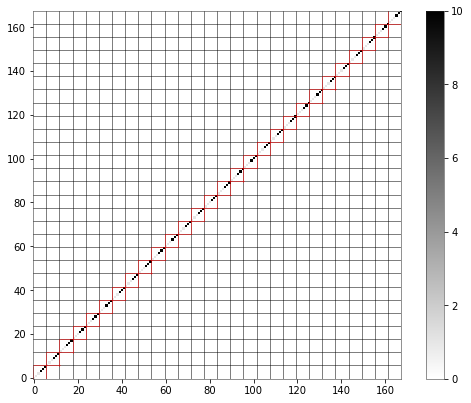

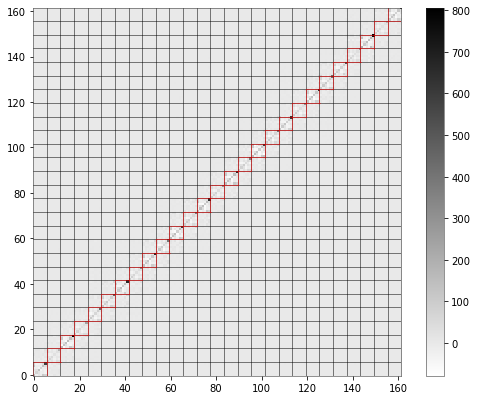

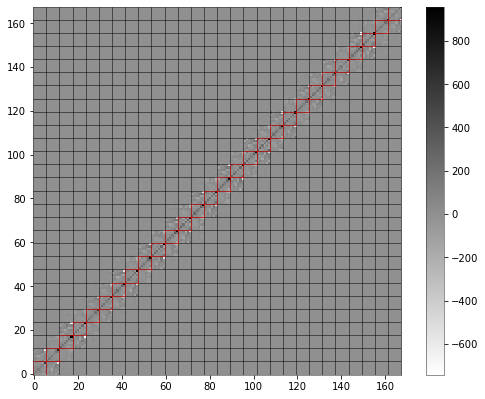

357.3163186623349
96.70857390574983


In [7]:

genstiff = GenStiffness(method='hybrid')
triadfn = 'methods/State/Nucleosome.state'
nuctriads = read_nucleosome_triads(triadfn)

BM_Kcomb_fn = 'MDParams/Calibrated/reg_Kcomb.npy'
BM_K_fn     = 'MDParams/Calibrated/reg_K.npy'
BM_mu0_fn   = 'MDParams/Calibrated/reg_mu0.npy'


nuc_Kcomb = np.load(BM_Kcomb_fn)
nuc_K     = np.load(BM_K_fn)
nuc_mu0   = np.load(BM_mu0_fn)


nuc_Kcomb = np.load('MDParams/nuc_midsteps_sym_Kcomb.npy')
nuc_Kcomb = np.load('MDParams/nuc_midsteps_Kcomb.npy')




left_open  = 0
right_open = 0     
  
seq = "ATCAATATCCACCTGCAGATACTACCAAAAGTGTATTTGGAAACTGCTCCATCAAAAGGCATGTTCAGCTGGAATCCAGCTGAACATGCCTTTTGATGGAGCAGTTTCCAAATACACTTTTGGTAGTATCTGCAGGTGGATATTGAT"  
# seq = "CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCTCTAGCACCGCTTAAACGCACGTACGCGCTGTCCCCCGCGTTTTAACCGCCAAGGGGATTACTCCCTAGTCTCCAGGCACGTGTCAGATATATACATCCTGT"

seq = 'ATTTGGCCTTAAAAAAACTTCCCCCTTCGCTATACAAGAGATTCATCGGAAAGATCAGTGGAGCGAACTGCCCTACATCATCCTAATGAGATTCGGTGCTGTTAATTGGGTACCAGACTTCCACGCGAAAAAATCGCGGGGGCACGA'
seq = 'ATTTGGCCTTAAAAAAACTTCCCCCTTCGCTATACAAGAGATTCATCGGAAAGATCAGTGGAGCGAACTGCCCTACATCATCCTAATGAGATTCGGTGCTGTTAATTGGGTACCAGACTTCCACGCGAAAAAATCGCGGGGGCACGA'

seq = ''.join(['ATCG'[np.random.randint(4)] for i in range(147)])

free_M,free_gs = genstiff.gen_params(seq,use_group=True)

        
# nucleosome_free_energy(groundstate,stiffmat,left_open,right_open,nuctriads,K)

# K = marginalize_diagonal_blocks(nuc_Kcomb)
# K = np.copy(Kd_reg)
# K = np.copy(Kd1)

diags = np.ones(len(nuc_Kcomb))*10
diags[0::6] = 1
diags[1::6] = 1
diags[2::6] = 1
K = np.diag(diags)

# K = np.eye(len(nuc_Kcomb))*20

# K = marginalize_diagonal_blocks(K)

# K = np.copy(Kdiag)
# K = np.copy(Kcomb)

F = binding_model_free_energy(
    free_gs,
    free_M,    
    nuc_mu0,
    # nuc_Kcomb,
    K,
    left_open,
    right_open,
    nuctriads,
    use_correction = True
)
print(F)

plot_matrix(K)

# Calculate Incidence Matrix
B, Pbar = coordinate_transformation(mu0s,sks)    
Kcomb_ = K + B.T @ Mm @ B
# calculate ground state
alpha = -np.linalg.inv(Kcomb_) @ B.T @ Mm @ Pbar

B, Pbar = coordinate_transformation_correction(mu0s,sks,alpha)
Kcomb_ = K + B.T @ Mm @ B

plot_matrix(Mm)
plot_matrix(B.T @ Mm @ B)

_, logdet = np.linalg.slogdet(Mm)
print(0.5*logdet)
_, logdet = np.linalg.slogdet(K)
print(0.5*logdet)


In [14]:

for i in range(28):
    seq = ''.join(['ATCG'[np.random.randint(4)] for i in range(147)])

    free_M,free_gs = genstiff.gen_params(seq,use_group=True)
    diags = np.ones(len(nuc_Kcomb))*10
    diags[0::6] = 1
    diags[1::6] = 1
    diags[2::6] = 1
    K = np.diag(diags)
    
    # K = np.copy(Kcomb)

    F = binding_model_free_energy(
        free_gs,
        free_M,    
        nuc_mu0,
        # nuc_Kcomb,
        K,
        left_open,
        right_open,
        nuctriads,
        use_correction = True
    )
    print(f'FE: {F["F"]}, S: {F["F_entropy"]}, H: {F["F_enthalpy"]}')



FE: 103.72257192963389, S: 50.84036532171649, H: 52.88220660791729
FE: 108.24652602398942, S: 50.90648824275149, H: 57.34003778123794
FE: 103.81651164237678, S: 50.88183455886701, H: 52.934677083509825
FE: 103.65497960709172, S: 50.82750812456288, H: 52.827471482528914
FE: 103.86038629396785, S: 50.788879231125065, H: 53.071507062842684
FE: 104.49665918360802, S: 50.991031255428425, H: 53.50562792817953
FE: 103.24140322232256, S: 50.89126765966057, H: 52.35013556266188
FE: 103.28905168914389, S: 50.85022804751111, H: 52.4388236416328
FE: 107.05281841042847, S: 51.0146189984041, H: 56.03819941202443
FE: 102.60181952328116, S: 50.8425125105648, H: 51.75930701271641
FE: 106.71320017190851, S: 50.75065296185153, H: 55.96254721005704
FE: 104.7531995617071, S: 50.83884398448049, H: 53.91435557722655
FE: 107.15811487989299, S: 50.796957421231355, H: 56.36115745866171
FE: 106.47559442444208, S: 50.72786887697225, H: 55.747725547469884
FE: 108.09792333123255, S: 50.85435432957706, H: 57.2435690